# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
!pip install pandas==0.23.4
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10)

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=228.45851719984765, mobile=True), User(purchased=False, time_on_site=245.21551458049706, mobile=True), User(purchased=True, time_on_site=205.3211252368272, mobile=True), User(purchased=False, time_on_site=183.56036528784034, mobile=True), User(purchased=False, time_on_site=36.49370220060807, mobile=True), User(purchased=False, time_on_site=99.70163567760756, mobile=False), User(purchased=False, time_on_site=257.18892472116653, mobile=False), User(purchased=True, time_on_site=509.80700881982546, mobile=False), User(purchased=False, time_on_site=15.08387140624919, mobile=True), User(purchased=True, time_on_site=276.4967948592766, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,228.458517,True
1,False,245.215515,True
2,True,205.321125,True
3,False,183.560365,True
4,False,36.493702,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2570402864042345,5.44502696907763,6.229050886794029,6.675777995927488,6.976722803666444,7.018417468480578,7.173687306979995,7.389245231944278,7.736745525966648,7.86643162623759,...,583.5765205160799,585.1878871346092,586.1546121546132,586.3453897806826,587.5347933781833,588.8831717674517,593.591600704933,595.2317835982531,597.700725240342,599.9897934729556
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,0,1,...,1,1,1,0,0,0,0,1,0,0
True,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,1,1,1,0,1,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [2]:
!pip install pandas==0.23.4
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:
per = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

In [4]:
per.shape


(1200, 4)

In [5]:
per.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
per = per.drop('Unnamed: 0', axis=1)

In [7]:
per.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [8]:
per.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


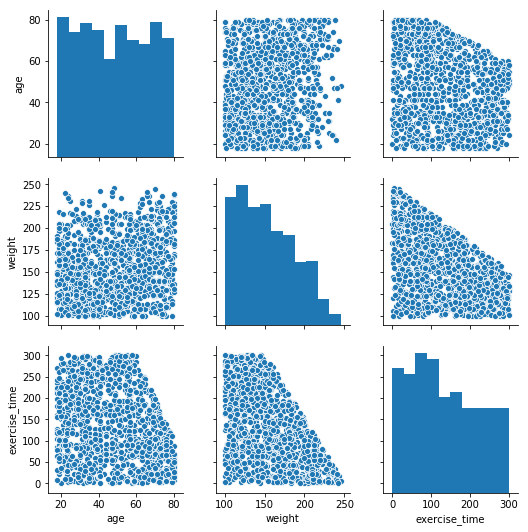

In [9]:
sns.pairplot(per)

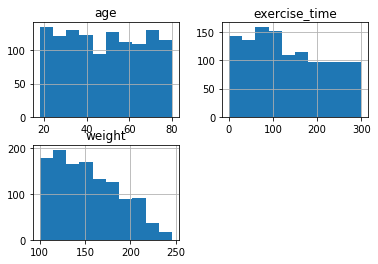

In [10]:
per.hist();

In [0]:
extime_bins = pd.cut(per['exercise_time'], 6)  
weight_bins = pd.cut(per['weight'], 6)
age_bins = pd.cut(per['age'], 6)


In [0]:
per['agebin']=age_bins

In [0]:
per.head()

In [19]:
pd.crosstab(weight_bins, extime_bins)

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
weight,,,,,,
"(99.854, 124.333]",34,42,51,51,46,70
"(124.333, 148.667]",37,47,27,62,63,68
"(148.667, 173.0]",37,63,49,44,42,18
"(173.0, 197.333]",47,45,41,31,4,0
"(197.333, 221.667]",52,62,26,2,0,0
"(221.667, 246.0]",34,5,0,0,0,0


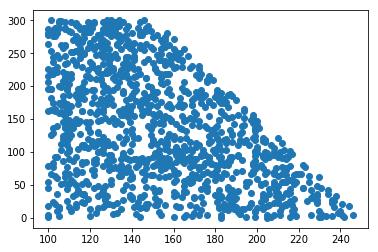

In [20]:
plt.scatter(per['weight'],per['exercise_time'])


In [21]:
pd.crosstab(weight_bins,age_bins)

age,"(17.938, 28.333]","(28.333, 38.667]","(38.667, 49.0]","(49.0, 59.333]","(59.333, 69.667]","(69.667, 80.0]"
weight,,,,,,
"(99.854, 124.333]",56,70,49,50,30,39
"(124.333, 148.667]",57,49,64,50,48,36
"(148.667, 173.0]",48,44,39,33,44,45
"(173.0, 197.333]",23,28,22,28,32,35
"(197.333, 221.667]",20,22,21,22,29,28
"(221.667, 246.0]",5,4,5,1,9,15


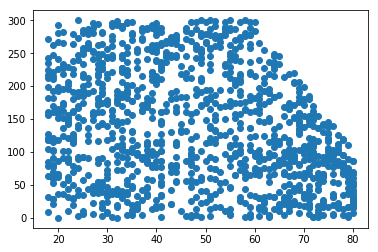

In [49]:
plt.scatter(per['age'],per['exercise_time'])

In [23]:
pd.crosstab(age_bins, extime_bins)

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
age,,,,,,
"(17.938, 28.333]",29,35,33,45,39,28
"(28.333, 38.667]",48,32,29,42,34,32
"(38.667, 49.0]",27,40,25,26,36,46
"(49.0, 59.333]",26,30,29,29,24,46
"(59.333, 69.667]",44,53,33,36,22,4
"(69.667, 80.0]",67,74,45,12,0,0


In [24]:
pd.crosstab(weight_bins, [age_bins, extime_bins])

age                (17.938, 28.333]                               \
exercise_time          (-0.3, 50.0] (50.0, 100.0] (100.0, 150.0]   
weight                                                             
(99.854, 124.333]                 4             4             10   
(124.333, 148.667]                5             8              5   
(148.667, 173.0]                  2             8              8   
(173.0, 197.333]                  7             6              6   
(197.333, 221.667]                6             9              4   
(221.667, 246.0]                  5             0              0   

age                                                              \
exercise_time      (150.0, 200.0] (200.0, 250.0] (250.0, 300.0]   
weight                                                            
(99.854, 124.333]              12             10             16   
(124.333, 148.667]             14             14             11   
(148.667, 173.0]               14             15              1   
(173.0, 197.333]                4              0              0   
(197.333, 221.667]              1              0              0   
(221.667, 246.0]                0              0              0   

age                (28.333, 38.667]                               \
exercise_time          (-0.3, 50.0] (50.0, 100.0] (100.0, 150.0]   
weight                                                             
(99.854, 124.333]                 7            12             10   
(124.333, 148.667]                6             5              2   
(148.667, 173.0]                 11             4              7   
(173.0, 197.333]                  7             6              7   
(197.333, 221.667]               13             5              3   
(221.667, 246.0]                  4             0              0   

age                                    ...       (59.333, 69.667]  \
exercise_time      (150.0, 200.0]      ...           (-0.3, 50.0]   
weight                                 ...                          
(99.854, 124.333]              16      ...                      4   
(124.333, 148.667]              9      ...                      5   
(148.667, 173.0]                8      ...                      7   
(173.0, 197.333]                8      ...                      7   
(197.333, 221.667]              1      ...                     12   
(221.667, 246.0]                0      ...                      9   

age                                                                            \
exercise_time      (50.0, 100.0] (100.0, 150.0] (150.0, 200.0] (200.0, 250.0]   
weight                                                                          
(99.854, 124.333]              8              6              6              5   
(124.333, 148.667]             8              7             16             10   
(148.667, 173.0]              14              8              7              7   
(173.0, 197.333]              10              8              7              0   
(197.333, 221.667]            13              4              0              0   
(221.667, 246.0]               0              0              0              0   

age                               (69.667, 80.0]                               \
exercise_time      (250.0, 300.0]   (-0.3, 50.0] (50.0, 100.0] (100.0, 150.0]   
weight                                                                          
(99.854, 124.333]               1             11            10             14   
(124.333, 148.667]              2             13            15              5   
(148.667, 173.0]                1             12            18             10   
(173.0, 197.333]                0             11            12             12   
(197.333, 221.667]              0             10            14              4   
(221.667, 246.0]                0             10             5              0   

age                                
exercise_time      (150.0, 200.0]  
weight          

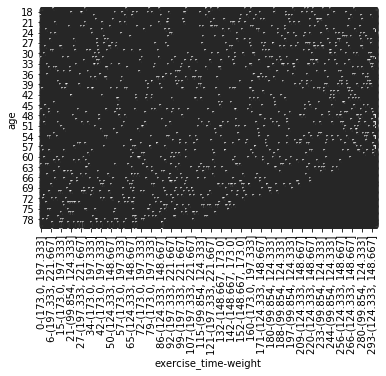

In [25]:
sns.heatmap(pd.crosstab(per['age'],  [per['exercise_time'], weight_bins] ),
            cmap="YlGnBu", annot=True, cbar=False);

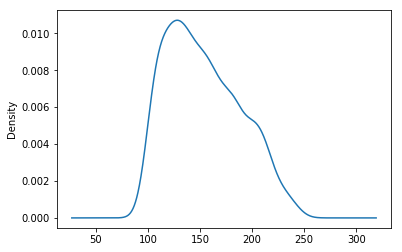

In [26]:
per['weight'].plot.density();

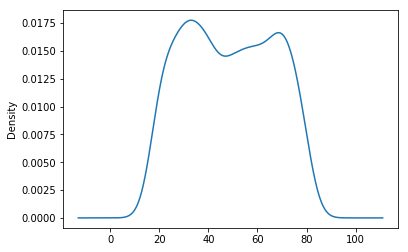

In [27]:
per['age'].plot.density();

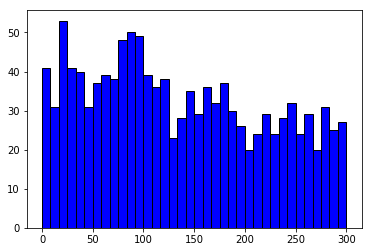

In [28]:
plt.hist(per['exercise_time'], color = 'blue', edgecolor = 'black',
         bins = int(180/5));


In [0]:
#ax = plt.axes(projection='3d')

from mpl_toolkits.mplot3d import Axes3D
# Data for three-dimensional scattered points


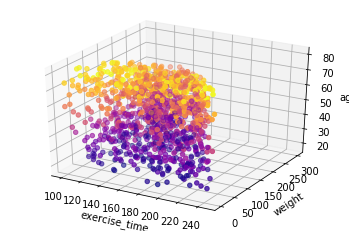

In [30]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
zdata = per['age']
xdata = per['weight']
ydata = per['exercise_time']
ax.set_xlabel('exercise_time')
ax.set_ylabel('weight')
ax.set_zlabel('age')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='plasma');


In [0]:
ct = pd.crosstab(weight_bins,[age_bins, weight_bins])



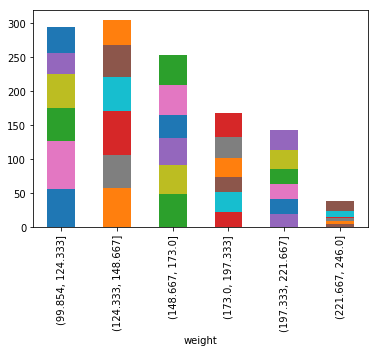

In [32]:
ct.plot(kind='bar', stacked=True, legend=False);

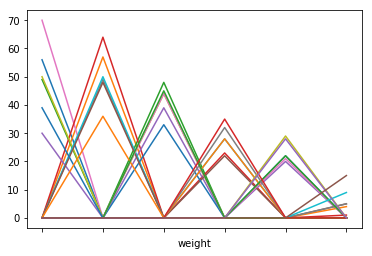

In [33]:
ct.plot(legend=False);

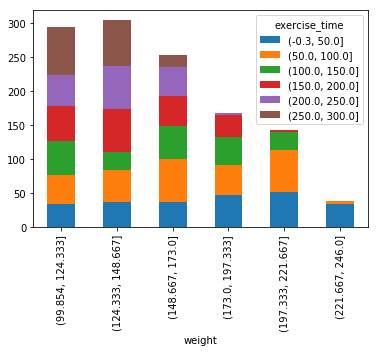

In [34]:
cq = pd.crosstab(weight_bins, extime_bins)
cq.plot(kind='bar', stacked=True)

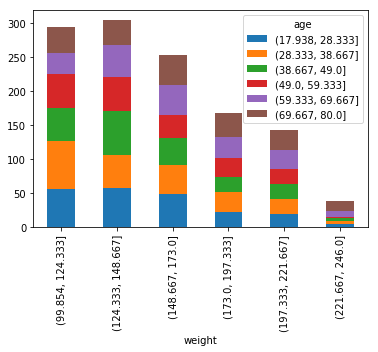

In [35]:
cq = pd.crosstab(weight_bins, age_bins)
cq.plot(kind='bar', stacked=True)

In [0]:
import seaborn as sns

#[0, 1, 2, 3, 4, u'D', 6, 7, 8, u's', u'|', 11, u'None', u'P', 9, u'x', u'X', 5, u'_', u'^', u' ', None, u'd', u'h', u'+', u'*', u',', u'o', u'.', u'1', u'p', u'3', u'2', u'4', u'H', u'v', u'', u'8', 10, u'&lt;', u'&gt;']


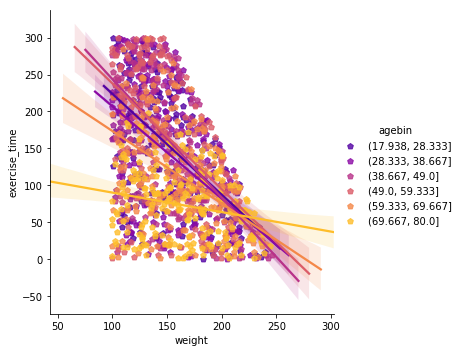

In [69]:
# sns.lmplot(x = per['exercise_time'], y = per['weight'], hue=age_bins,data=per);
sns.lmplot( x='weight', y='exercise_time', data=per, hue='agebin', fit_reg=True, legend=True, palette='plasma', robust=True,markers='p',)
fig.suptitle("Exercise vs Weight of Age Groups", fontsize=12);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
All are continuous variables, except the Unnamed:0.

2.  What are the relationships between the variables?
There are numerous relationships we could impose on the data however, most if not all are unreliable. It would be a stretch but we could say that age and exercise time have a correlation on the last days end of the age range.

3.  Which relationships are "real", and which spurious?
Age and exercise time could be considered real while almost anything else is spurious due to confounding variables.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [71]:
from google.colab import files
uploaded = files.upload()


Saving Alabama.csv to Alabama.csv


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import io


In [0]:
alabama = pd.read_csv(io.BytesIO(uploaded['Alabama.csv']), sep="\t")

In [74]:
alabama.head()

,Year,Year Code,State,State Code,Births
0,2007,2007,Alabama,1,64804
1,2008,2008,Alabama,1,64546
2,2009,2009,Alabama,1,62475
3,2010,2010,Alabama,1,60050
4,2011,2011,Alabama,1,59354


In [0]:
bama_new = alabama[['Year', 'Births']].copy()

In [76]:
from google.colab import files
uploaded = files.upload()

Saving alcohol-consumption-per-person-us.csv to alcohol-consumption-per-person-us.csv


In [0]:
alcohol = pd.read_csv(io.BytesIO(uploaded['alcohol-consumption-per-person-us.csv']))

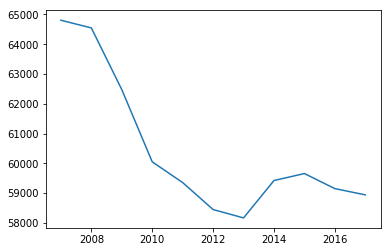

In [87]:
plt.plot(alabama.Year, alabama.Births);

In [78]:
alcohol.head()

,Entity,Code,Year,Spirits (litres per person),Beer (litres per person),Wine (litres per person)
0,United States,USA,1850,7.12,0.53,0.30
1,United States,USA,1860,8.18,1.02,0.38
2,United States,USA,1870,5.79,1.67,0.38
3,United States,USA,1880,3.86,2.12,0.53
4,United States,USA,1890,3.60,3.41,0.53


In [0]:
alcohol = alcohol.drop(['Entity', 'Code'], axis=1)



In [80]:
alcohol.shape

(94, 4)

In [0]:
names = ["year", "liq", "beer", "wine"]
alcohol.columns = names

In [82]:
alcohol.head()

,year,liq,beer,wine
0,1850,7.12,0.53,0.30
1,1860,8.18,1.02,0.38
2,1870,5.79,1.67,0.38
3,1880,3.86,2.12,0.53
4,1890,3.60,3.41,0.53


In [103]:
alcohol['births']=bama_new.Births
alcohol.head()


,year,liq,beer,wine,combined,births
0,1850,7.12,0.53,0.30,7.95,64804.0
1,1860,8.18,1.02,0.38,9.58,64546.0
2,1870,5.79,1.67,0.38,7.84,62475.0
3,1880,3.86,2.12,0.53,6.51,60050.0
4,1890,3.60,3.41,0.53,7.54,59354.0


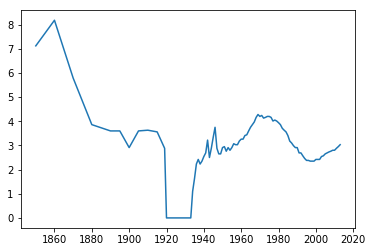

In [104]:
plt.plot(alcohol['year'], alcohol['liq']);
alcohol['combined'] = alcohol.beer + alcohol.liq + alcohol.wine *10000

In [109]:
alcohol.head()
alcohol.shape

(94, 6)

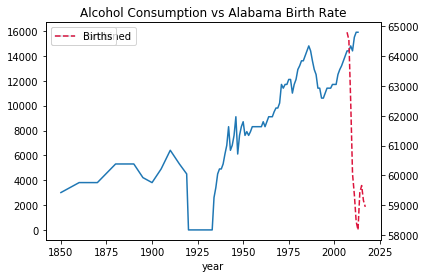

In [122]:

fig, ax = plt.subplots()
ax2 = ax.twinx()

alcohol.plot(x = 'year', y = "combined", ax=ax)
bama_new.plot(x="Year", y='Births', ax=ax2, ls="--", color="crimson")
plt.title("Alcohol Consumption vs Alabama Birth Rate")
plt.show()

SyntaxError: ignored